In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig


/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

In [ ]:
data_file = "/content/drive/MyDrive/IR/spam.csv"
data=pd.read_csv(data_file,encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
print(f'File has {data.shape[0]} rows and {data.shape[1]} columns')

File has 5572 rows and 5 columns


In [ ]:
data = data[['v1', 'v2']]
data = data.rename(columns={'v1': 'label', 'v2': 'text'})
print(f'File has {data.shape[0]} rows and {data.shape[1]} columns')
data.head()

File has 5572 rows and 2 columns


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data = data.dropna()                                                           # Drop NaN valuues, if any
data = data.reset_index(drop=True)                                             # Reset index after dropping the columns/rows with NaN values
data = shuffle(data)                                                         # Shuffle the dataset
print('Available labels: ',data.label.unique())                              # Print all the unique labels in the dataset
# data['text']=data['text'].map(preprocess_sentence)                           # Clean the text column using preprocess_sentence function defined above
num_classes=len(data.label.unique())
data['label'] = data['label'].map({'ham':0,'spam':1})

Available labels:  ['ham' 'spam']


<Axes: >

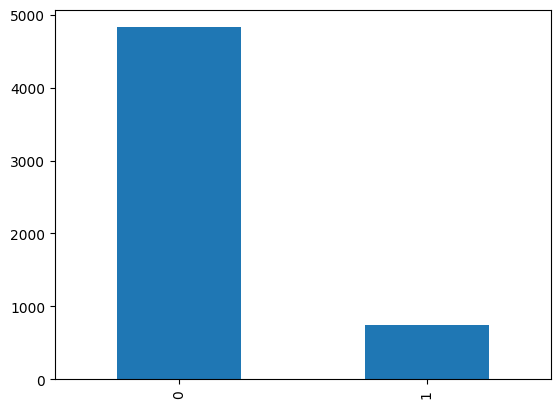

In [ ]:
data['label'].value_counts().plot.bar()

In [ ]:
print(f'File has {data.shape[0]} rows and {data.shape[1]} columns')
data.head()


File has 5572 rows and 2 columns


,label,text
406,0,All was well until slightly disastrous class t...
3484,0,No:-)i got rumour that you going to buy apartm...
1583,0,"It's cool, let me know before it kicks off aro..."
765,1,UR awarded a City Break and could WIN a å£200 ...
3378,0,Dear umma she called me now :-)


In [ ]:
from transformers import BertTokenizer, TFBertModel, BertConfig
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer.json


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.js

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/model.safetensors
Loaded 109,482,240 parameters in the TF 2.0 model.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens,len(tokens))

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.'] 18


In [ ]:
tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True, max_length =30, pad_to_max_length = True, return_attention_mask = True)
tokenized_sequence

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
sentences = data['text']
labels = data['label']
len(sentences),len(labels)

(5572, 5572)

In [ ]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.array(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)


In [ ]:
len(input_ids),len(attention_masks),len(labels)


(5572, 5572, 5572)

In [ ]:
!mkdir data

In [ ]:
print('Preparing the pickle file.....')

pickle_inp_path='./data/bert_inp.pkl'
pickle_mask_path='./data/bert_mask.pkl'
pickle_label_path='./data/bert_label.pkl'

with open(pickle_inp_path, 'wb') as f:
    pickle.dump(input_ids, f)

with open(pickle_mask_path, 'wb') as f:
    pickle.dump(attention_masks, f)

with open(pickle_label_path, 'wb') as f:
    pickle.dump(labels, f)

print('Pickle files saved as', pickle_inp_path, pickle_mask_path, pickle_label_path)


Preparing the pickle file.....
Pickle files saved as ./data/bert_inp.pkl ./data/bert_mask.pkl ./data/bert_label.pkl


In [ ]:
print('Loading the saved pickle files..')

with open(pickle_inp_path, 'rb') as f:
    input_ids = pickle.load(f)

with open(pickle_mask_path, 'rb') as f:
    attention_masks = pickle.load(f)

with open(pickle_label_path, 'rb') as f:
    labels = pickle.load(f)

print(f'Input shape {input_ids.shape} Attention mask shape {attention_masks.shape} Input label shape {labels.shape}')


Loading the saved pickle files..
Input shape (5572, 64) Attention mask shape (5572, 64) Input label shape (5572,)


In [ ]:
train_inp,test_inp,train_label,test_label,train_mask,test_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)
train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(train_inp,train_label,train_mask, test_size=0.2 )

print('Train inp shape {} test input shape {} val input shape {}\nTrain label shape {} test label shape {} val label shape {}\nTrain attention mask shape {} test attention mask shape {} val attention mask shape {}'.format(train_inp.shape,test_inp.shape,val_inp.shape,train_label.shape,test_label.shape,val_label.shape,train_mask.shape, test_mask.shape,val_mask.shape))


Train inp shape (3565, 64) test input shape (1115, 64) val input shape (892, 64)
Train label shape (3565,) test label shape (1115,) val label shape (892,)
Train attention mask shape (3565, 64) test attention mask shape (1115, 64) val attention mask shape (892, 64)


In [ ]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Bert Model None


In [ ]:
history = bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=3,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)


Epoch 1/3
112/112 [==============================] - 126s 518ms/step - loss: 0.1482 - accuracy: 0.9428 - val_loss: 0.0518 - val_accuracy: 0.9843
Epoch 2/3
112/112 [==============================] - 51s 458ms/step - loss: 0.0235 - accuracy: 0.9952 - val_loss: 0.0309 - val_accuracy: 0.9910
Epoch 3/3
112/112 [==============================] - 49s 437ms/step - loss: 0.0138 - accuracy: 0.9966 - val_loss: 0.0332 - val_accuracy: 0.9922


In [ ]:
%load_ext tensorboard


In [ ]:
log_dir='tensorboard_data/tb_bert'
%tensorboard --logdir {log_dir} --port 6007


<IPython.core.display.Javascript object>

In [ ]:
model_save_path='./models/bert_model.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([test_inp,test_mask],batch_size=32)
pred_labels = preds.logits.argmax(axis=1)
f1 = f1_score(test_label,pred_labels,average="macro")
print('F1 score',f1)
print('Classification Report')
print(classification_report(test_label,pred_labels,target_names=["Ham","Spam"]))

print('Training and saving built model.....')


In [ ]:
np.unique(pred_labels)

array([0, 1])

In [ ]:

unique, counts = np.unique(pred_labels, return_counts=True)

plt.bar(unique, counts)
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Count of Unique Values')

plt.show()

